In [1]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

!unzip "5y9wdsg2zt-2.zip" 
!unrar x "Concrete Crack Images for Classification.rar"

Streaming output truncated to the last 5000 lines.
Extracting  Negative/15002.jpg                                            88%  OK 
Extracting  Negative/15003.jpg                                            88%  OK 
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  Negative/15012.jp

In [2]:
import os 
import cv2
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.utils import plot_model
from keras.callbacks import TensorBoard,EarlyStopping
from keras.layers import InputLayer,Conv2D,MaxPool2D,Dense,GlobalAveragePooling2D

In [3]:
negative_path = os.path.join(os.getcwd(),"Negative")
positive_path = os.path.join(os.getcwd(),"Positive")

# load the data as tensorfloww dataset using the special method
negative_image_path = sorted(glob.glob(os.path.join(negative_path,'*.jpg')))
positive_image_path = sorted(glob.glob(os.path.join(positive_path,'*.jpg')))
print(f'Total negative image: {len(negative_image_path)}, Total positive image: {len(positive_image_path)}')

# target variable
list_positive = [0 for i in range(len(positive_image_path))] # zero for positive
list_negative = [1 for i in range(len(negative_image_path))] # one for negative
y = list_positive + list_negative

# reference positive and negative binary
ref = {0:'positive', 1:'negative'}

Total negative image: 20000, Total positive image: 20000


In [4]:
# read image and resize to smaller resolution for positive image and negative image
x_img = positive_image_path + negative_image_path

x = []
for img in range(len(x_img)):
    img_arr=cv2.imread(x_img[img],0)
    img_arr=cv2.resize(img_arr,(50,50))
    x.append(img_arr)

# set the dimension
x = np.expand_dims(np.array(x),axis=-1)/255.0
y = np.expand_dims(np.array(y),axis=-1)

#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state=42,shuffle=True,test_size=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                    

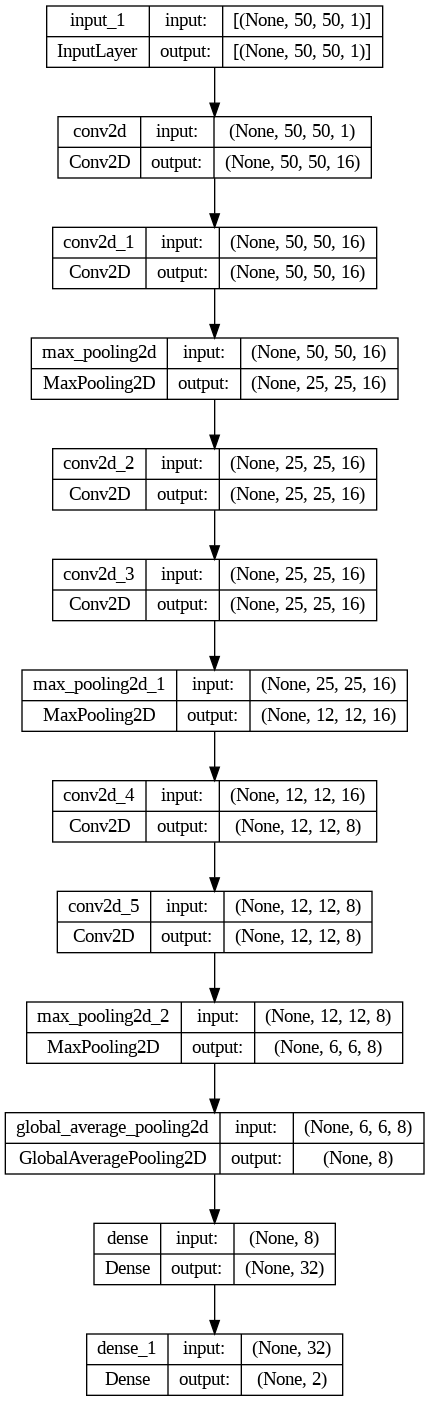

In [5]:
img_shape = x_train[0].shape
nclass= len(np.unique(y_train))

# create the CNN with sequential api
model = Sequential()
model.add(InputLayer(input_shape=img_shape)) # input layers

model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(8,(3,3),padding='same',activation='relu'))
model.add(Conv2D(8,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D())

model.add(GlobalAveragePooling2D())
model.add(Dense(32,activation='relu'))
model.add(Dense(nclass,activation='softmax')) #output layers
model.summary()

# model compile and plot the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
plot_model(model,show_shapes=True)

In [6]:
# include tensorboard and early stopping 
log_path = os.path.join(os.getcwd(),datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = TensorBoard(log_dir=log_path)
es = EarlyStopping(monitor="loss", patience=1)

# model training
batch_size = 16
epoch = 5
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=batch_size,epochs=epoch,callbacks=[tb,es])

Epoch 1/5
2000/2000 [==============================] - 201s 99ms/step - loss: 0.0730 - accuracy: 0.9699 - val_loss: 0.0277 - val_accuracy: 0.9916
Epoch 2/5
2000/2000 [==============================] - 193s 96ms/step - loss: 0.0312 - accuracy: 0.9903 - val_loss: 0.0280 - val_accuracy: 0.9929
Epoch 3/5
2000/2000 [==============================] - 193s 96ms/step - loss: 0.0244 - accuracy: 0.9926 - val_loss: 0.0247 - val_accuracy: 0.9916
Epoch 4/5
2000/2000 [==============================] - 193s 96ms/step - loss: 0.0178 - accuracy: 0.9944 - val_loss: 0.0170 - val_accuracy: 0.9958
Epoch 5/5
2000/2000 [==============================] - 191s 96ms/step - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.0126 - val_accuracy: 0.9970


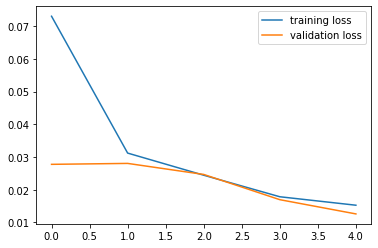

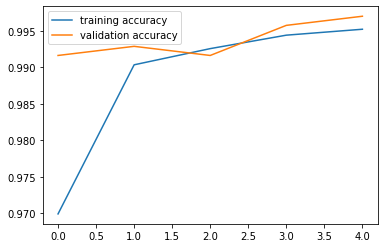

In [7]:
# model analysis
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

250/250 [==============================] - 17s 67ms/step


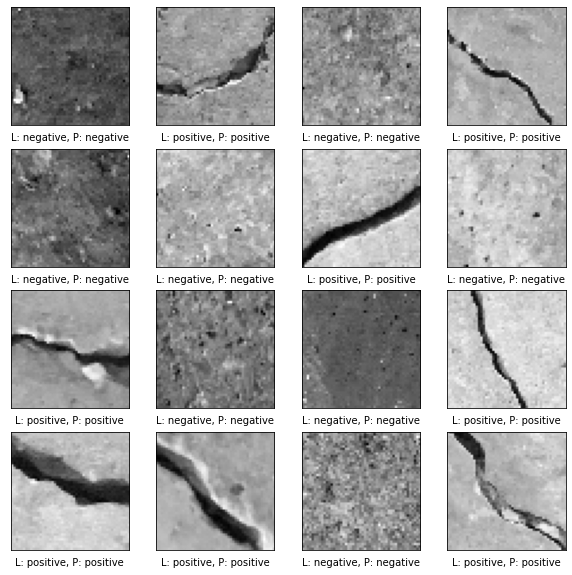

In [8]:
# model prediction
y_pred = np.argmax(model.predict(x_test),axis=1)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i],axis=-1),cmap='gray')
    plt.xlabel(f'L: {ref[y_test.tolist()[i][0]]}, P: {ref[y_pred.tolist()[i]]}') # L means Label and P means Prediction
plt.show()

In [9]:
# model deployment
model.save('model.h5')